In [1]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import pandas as pd

In [2]:
dataset_path = "/kaggle/input/my-fish-dataset/mydataset"  # Replace with your actual path

# Initialize lists to store file paths and class names
file_paths = []
classes = []

# Loop through each folder (class) and each file within it
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            file_paths.append(os.path.join(class_folder, filename))
            classes.append(class_name)

# Create the DataFrame
df = pd.DataFrame({'file_path': file_paths, 'class': classes})

# Display the DataFrame
print(df.sample(n=10, random_state=1))

                                              file_path  \
6487  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
599   /kaggle/input/my-fish-dataset/mydataset/Yellow...   
5907  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
3260  /kaggle/input/my-fish-dataset/mydataset/Betta ...   
6276  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
4203  /kaggle/input/my-fish-dataset/mydataset/Blue t...   
2025  /kaggle/input/my-fish-dataset/mydataset/Archer...   
6844  /kaggle/input/my-fish-dataset/mydataset/Clown ...   
3842  /kaggle/input/my-fish-dataset/mydataset/Betta ...   
2241  /kaggle/input/my-fish-dataset/mydataset/Archer...   

                         class  
6487  Clown Sword Trigger Fish  
599                Yellow Tang  
5907  Clown Sword Trigger Fish  
3260                Betta Fish  
6276  Clown Sword Trigger Fish  
4203                 Blue tang  
2025               Archer Fish  
6844  Clown Sword Trigger Fish  
3842                Betta Fish  
2241               A

In [3]:
from sklearn.model_selection import train_test_split

# First, split into train+val and test
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['class'], random_state=1)

# Then split train+val into train and val
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['class'], random_state=1)

# Print the number of instances in each set
print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Training set: 4401
Validation set: 1468
Test set: 1036


In [4]:
import tensorflow as tf

# Define the ImageDataGenerators with augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create the data generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',  # Column in the dataframe containing file paths
    y_col='class',      # Column in the dataframe containing class labels
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Typically, we don't shuffle the test set
)

Found 4401 validated image filenames belonging to 5 classes.
Found 1468 validated image filenames belonging to 5 classes.
Found 1036 validated image filenames belonging to 5 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load InceptionV3 with pre-trained ImageNet weights, excluding the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding Dense Layers with Batch Normalization and Dropout
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer with softmax for a 5-class classification
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Define the optimizer with learning rate scheduling
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,362,405 (85.31 MB)

 Trainable params: 558,853 (2.13 MB)

 Non-trainable params: 21,803,552 (83.17 MB)

In [6]:
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

callbacks_inception = [checkpoint, reduce_lr]

# Fit the model as you did with ResNet
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=callbacks_inception
)


Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731356266.246366      65 service.cc:145] XLA service 0x7865c8004f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731356266.246417      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/138 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.1719 - loss: 3.3899    

I0000 00:00:1731356277.684001      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


138/138 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.3497 - loss: 2.7238 - val_accuracy: 0.8529 - val_loss: 1.0935 - learning_rate: 1.0000e-04
Epoch 2/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 127s 883ms/step - accuracy: 0.7239 - loss: 1.3949 - val_accuracy: 0.9210 - val_loss: 0.8513 - learning_rate: 1.0000e-04
Epoch 3/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 126s 874ms/step - accuracy: 0.8255 - loss: 1.1299 - val_accuracy: 0.9462 - val_loss: 0.7803 - learning_rate: 1.0000e-04
Epoch 4/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 125s 864ms/step - accuracy: 0.8458 - loss: 1.0251 - val_accuracy: 0.9578 - val_loss: 0.7437 - learning_rate: 1.0000e-04
Epoch 5/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 126s 873ms/step - accuracy: 0.8864 - loss: 0.9592 - val_accuracy: 0.9639 - val_loss: 0.7222 - learning_rate: 1.0000e-04
Epoch 6/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 126s 874ms/step - accuracy: 0.8990 - loss: 0.9144 - val_accuracy: 0.9673 - val_loss: 0.7105 - learning_rate: 1.0000e-04
Epoch 7/60
138/138 ━━━━━━━━━━━━━━━━━━━━ 127s 884ms/ste

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9925 - loss: 0.3121
Test Accuracy: 0.9923
Test Loss: 0.3175


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 576ms/step


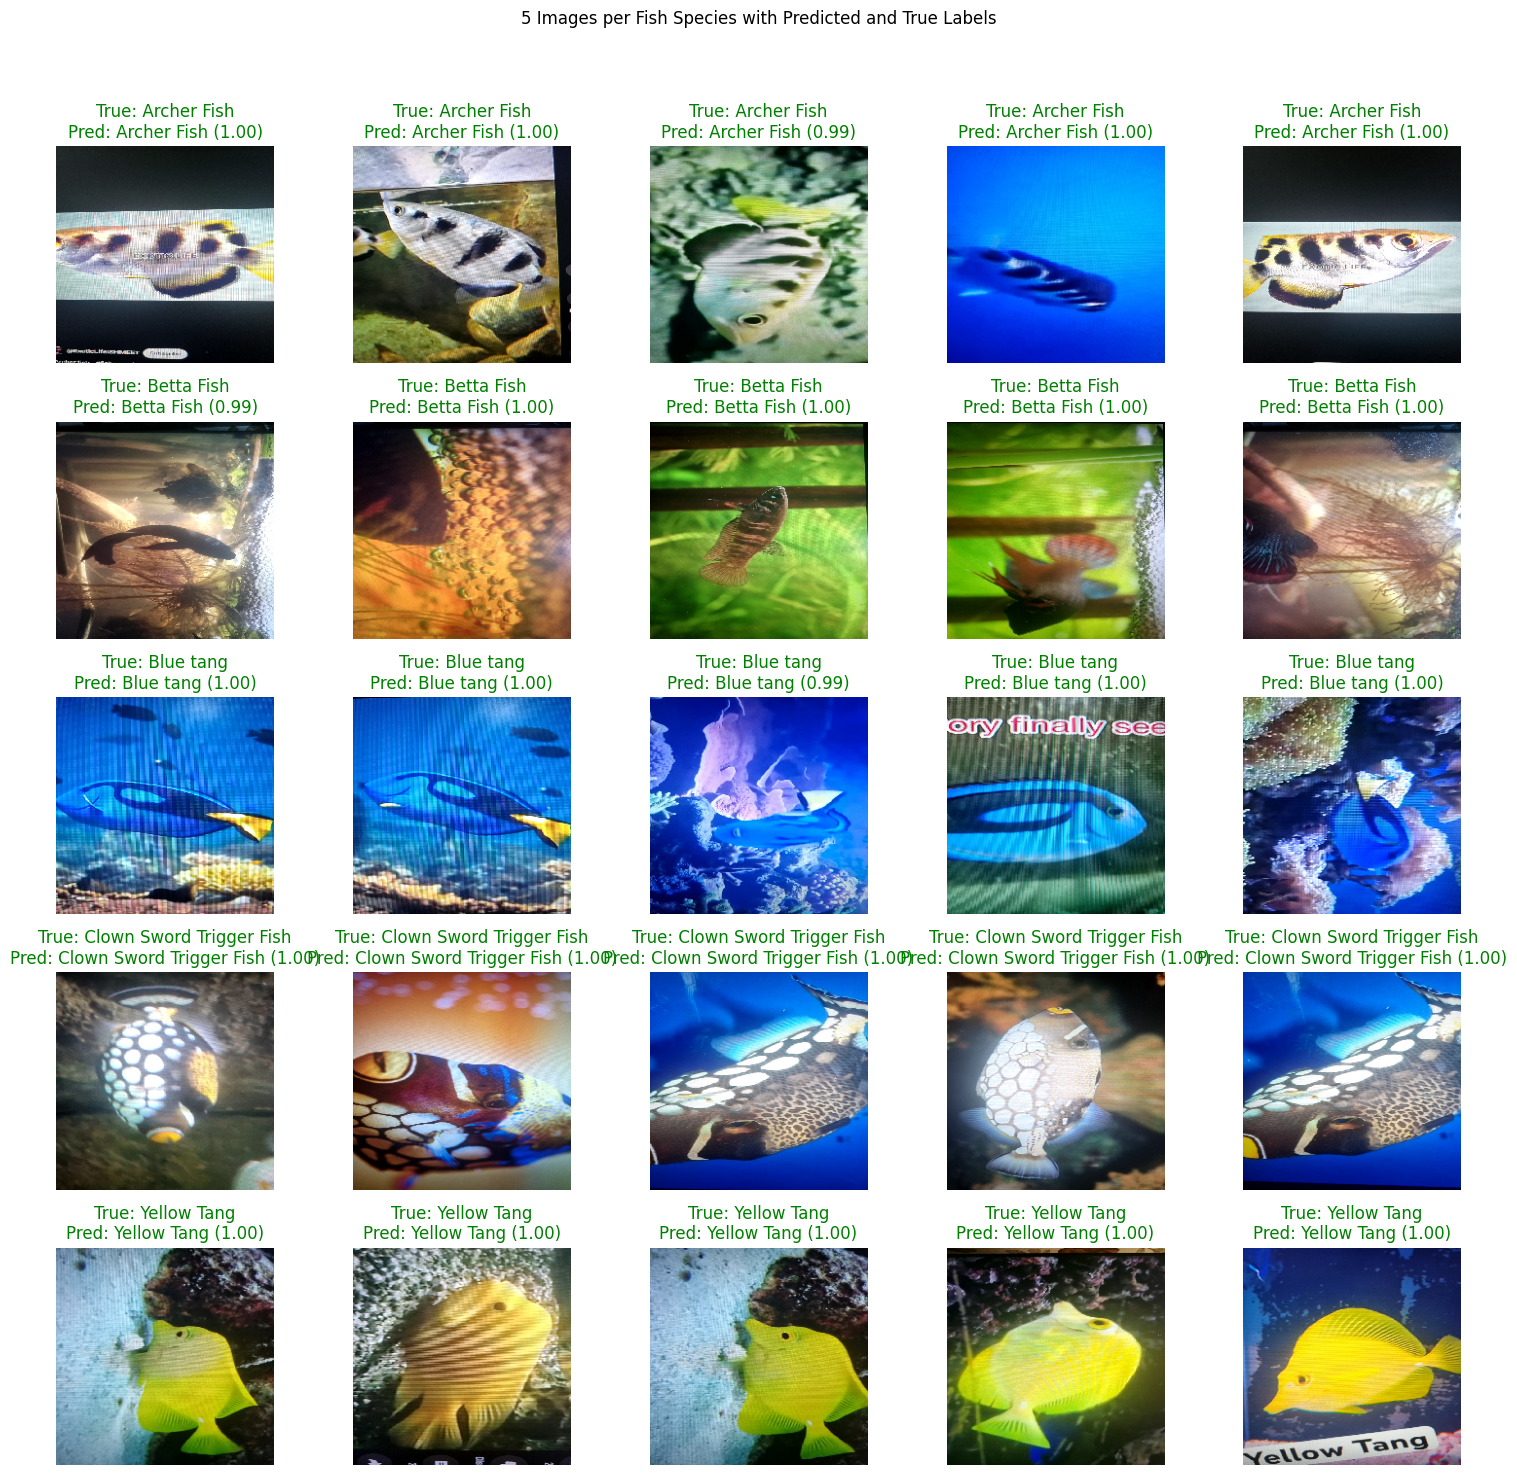

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get the true labels and predicted labels with confidence scores for the test set
test_generator.reset()  # Ensure the generator is at the start
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Add true labels and predicted labels with confidence scores to test_df
test_df['pred_class'] = predicted_classes
test_df['pred_conf'] = np.max(predictions, axis=1)
test_df['true_class'] = true_classes

# Plot 5 images per class with predictions, true labels, and confidence
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('5 Images per Fish Species with Predicted and True Labels')

for class_idx, class_name in enumerate(class_labels):
    # Filter test_df for the current class and sample 5 images
    class_df = test_df[test_df['true_class'] == class_idx].sample(5, random_state=1)
    
    for img_idx, (idx, row) in enumerate(class_df.iterrows()):
        img_path = row['file_path']
        true_label = class_labels[row['true_class']]
        pred_label = class_labels[row['pred_class']]
        confidence = row['pred_conf']

        # Load and plot the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        axes[class_idx, img_idx].imshow(img)
        axes[class_idx, img_idx].axis('off')
        
        # Add title with true and predicted labels and confidence
        axes[class_idx, img_idx].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})",
                                           color=("green" if true_label == pred_label else "red"))

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.95])  

# Save the plot as an image
output_image_path = '/kaggle/working/fish_species_predictions.png'  # Specify the path where to save the image
plt.savefig(output_image_path)

# Show the plot
plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 561ms/step


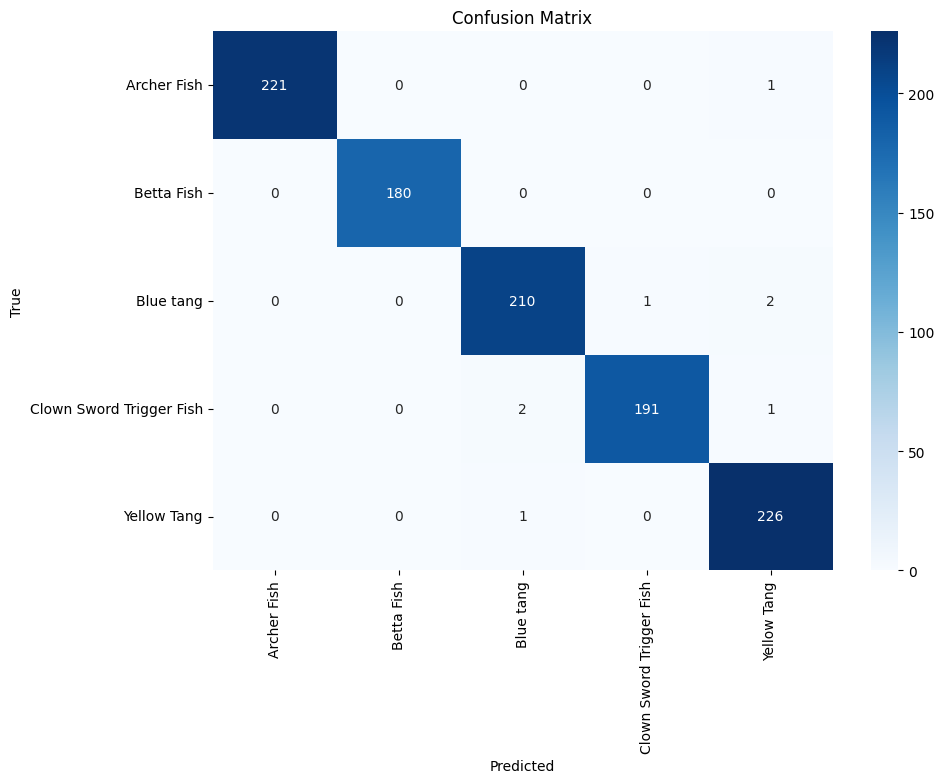

                          precision    recall  f1-score   support

             Archer Fish       1.00      1.00      1.00       222
              Betta Fish       1.00      1.00      1.00       180
               Blue tang       0.99      0.99      0.99       213
Clown Sword Trigger Fish       0.99      0.98      0.99       194
             Yellow Tang       0.98      1.00      0.99       227

                accuracy                           0.99      1036
               macro avg       0.99      0.99      0.99      1036
            weighted avg       0.99      0.99      0.99      1036



In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Step 1: Load the trained model from a specified path
model_path = '/kaggle/working/best_model.keras'  # Replace with your actual model path
model = tf.keras.models.load_model(model_path)

# Step 2: Generate predictions and true labels
y_true = test_generator.classes  # True labels
y_pred_prob = model.predict(test_generator)  # Model predictions (probabilities)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = sorted(train_generator.class_indices.keys())  # Class names

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save the plot as an image
confusion_matrix_image_path = '/kaggle/working/confusion_matrix.png'  # Specify the path where to save the image
plt.savefig(confusion_matrix_image_path)

# Show the plot
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


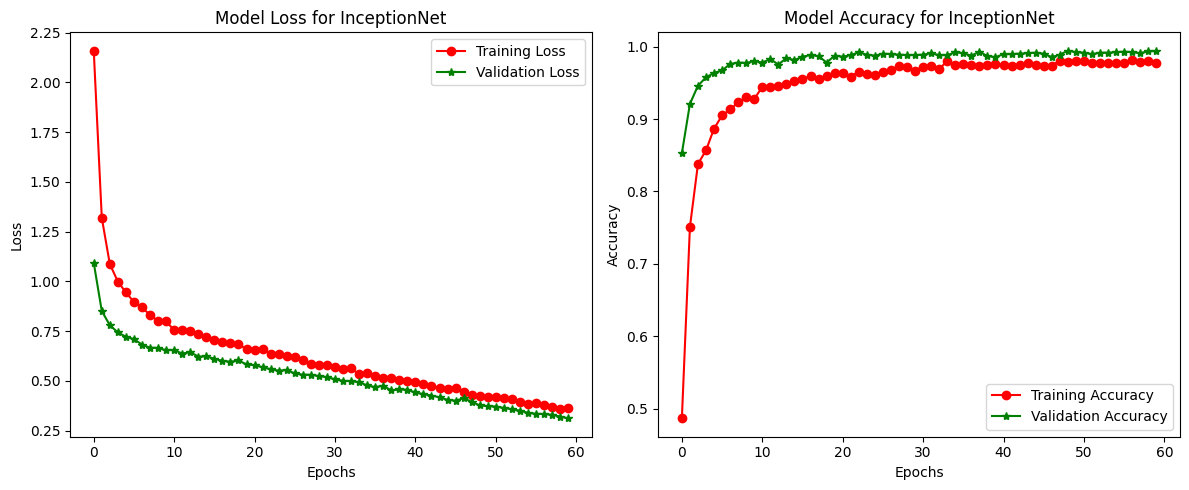

In [10]:
from matplotlib import pyplot as plt

# Create the plot
plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='r', label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], color='g', label='Validation Loss', marker='*')
plt.title('Model Loss for InceptionNet')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='r', label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], color='g', label='Validation Accuracy', marker='*')
plt.title('Model Accuracy for InceptionNet')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Adjust layout
plt.tight_layout()

# Save the plot as an image file
plt.savefig(r"InceptionNet_model_performance.png")  # Corrected line

# Display the plot
plt.show()
